<a href="https://colab.research.google.com/github/camdenmcgath/Artificial-Judge/blob/master/supreme_court_judge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install evaluate transformers seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import re
import evaluate
import numpy as np
import transformers as trans
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer, LongformerTokenizer, LongformerForSequenceClassification
import torch
from torch.optim import AdamW, lr_scheduler
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline, BSpline
import nltk
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from sklearn.metrics import confusion_matrix
import seaborn as sns

import os
import gc
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:2048"


In [3]:
cases = pd.read_csv("justice.csv")
cases.dropna(inplace=True)
cases.drop(columns=['Unnamed: 0', 'ID', 'name', 'href', 'docket', 'term',  
                    'majority_vote', 'minority_vote', 'decision_type', 'disposition', 'issue_area'], inplace=True)

In [4]:
cases = cases.rename(columns={'first_party_winner': 'winning_party_idx'})
for i, row in cases.iterrows():
    if row['winning_party_idx'] == True:
        cases.loc[i, 'winning_party_idx'] = 0
    else:
        cases.loc[i, 'winning_party_idx'] = 1

In [5]:
cases['facts'] = cases['facts'].str.replace(r'<[^<]+?>', '', regex=True)
cases['facts'] = cases['facts'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\'\s]', '', x))
#cases['facts'] = cases['facts'].str.lower()

def word_count(text):
  return len(text.split())

cases['facts_len'] = cases['facts'].apply(word_count)
cases['facts_len'].describe()

count    3098.000000
mean      173.816979
std        82.888975
min         2.000000
25%       119.000000
50%       164.000000
75%       216.000000
max       966.000000
Name: facts_len, dtype: float64

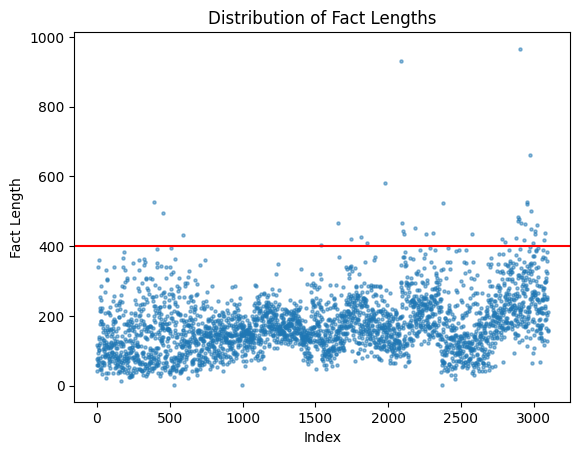

Percentage of cases with fact word no greater than 390: 98.52


In [6]:
# Create a scatterplot of the fact lengths
plt.scatter(range(len(cases['facts_len'])), cases['facts_len'], s=5, alpha=0.5)

plt.axhline(y=400, color='red')

plt.xlabel('Index')
plt.ylabel('Fact Length')
plt.title('Distribution of Fact Lengths')

plt.show()

# Count the number of facts below 2500 length
num_short_facts = len(cases[cases['facts_len'] <= 390])

# Calculate the percentage of short facts
percentage_short_facts = num_short_facts / len(cases) * 100
print(f"Percentage of cases with fact word no greater than 390: {percentage_short_facts:.2f}")

In [7]:
cases['facts'] = cases.loc[cases['facts_len'] <= 390, 'facts']
cases['facts'] = cases.apply(lambda x: f"{x['first_party']} [SEP] {x['second_party']} [SEP] {x['facts']}", axis=1)
cases = cases.drop(columns=['first_party', 'second_party', 'facts_len'])

train_facts, val_facts, train_winners,  val_winners = train_test_split(
    cases['facts'], cases['winning_party_idx'], test_size=0.20)

train_facts, val_facts = train_facts.tolist(), val_facts.tolist()
train_winners, val_winners = [str(i) for i in train_winners], [str(i) for i in val_winners]

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
train_encodings = tokenizer(train_facts, padding=True)
val_encodings = tokenizer(val_facts, padding=True)


In [8]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(int(self.labels[idx]))
        type(item)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TextDataset(train_encodings, train_winners)
val_dataset = TextDataset(val_encodings, val_winners)


In [9]:
#Load pretrained model
model = BertForSequenceClassification.from_pretrained('bert-base-cased', 
                                                      num_labels=2, 
                                                      hidden_dropout_prob=0.4,
                                                      attention_probs_dropout_prob=0.4)

training_args = TrainingArguments(
    output_dir="test_trainer", 
    logging_dir='logs', 
    evaluation_strategy="epoch",
    per_device_train_batch_size=48,  
    per_device_eval_batch_size=48,
    num_train_epochs=5,
    logging_steps=50,
)
metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return {"predictions": predictions, "labels": labels}

class CustomTrainer(Trainer):
  def evaluate(eval_dataset):
    logits, labels = eval_dataset
    predictions = np.argmax(logits, axis=1)
    return 0

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss


In [ ]:
# Evaluate on the validation set
result = trainer.evaluate()

# Extract the predicted and true labels from the evaluation results
y_pred = result.predictions.argmax(axis=1)
y_true = result.label_ids

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()